In [2]:
%%time
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine

# Sample DataFrame (replace this with your actual data)
data = {
    'maturity_value': [1000, 2000, 1500, 1200, 1800],
    'category': ['S.A', 'I.T', 'D.A', 'T.H', 'J.K'],
    'currency': ['USD', 'GBP', 'USD', 'JPY', 'GBP'],
    'amount': [500, 800, 600, 700, 900]
}

# Create a DataFrame with 10,000 records by repeating the sample data
num_records = 500
data_extended = {key: np.tile(values, num_records // len(values)) for key, values in data.items()}
data = pd.DataFrame(data_extended)

# Encode categorical variables
label_encoders = {}
categorical_vars = ['category', 'currency']
for var in categorical_vars:
    le = LabelEncoder()
    data[var] = le.fit_transform(data[var])
    label_encoders[var] = le
    

df = data

# Parameters
radius = 500  # Adjust the radius as needed
variables_to_process = ['maturity_value', 'category', 'currency', 'amount']

# Convert DataFrame to NumPy array for faster processing
data_array = df[variables_to_process].values

# Calculate lower and upper bounds for efficient masking
lower_bound = data_array - radius
upper_bound = data_array + radius

# Calculate the masks for density-based features using vectorized operations
masks = (lower_bound <= data_array[:, None]) & (upper_bound >= data_array[:, None])


# Calculate density-based features using vectorized operations
for idx, var in enumerate(variables_to_process):
    # Local Density Percentile
    df[f'{var}_local_density_percentile'] = np.mean(masks[:, :, idx], axis=1)
    
    # Local Density Ratio
    df[f'{var}_local_density_ratio'] = np.sum(masks[:, :, idx], axis=1) / df.shape[0]
    
    # Density Ranking
    df[f'{var}_density_rank'] = np.argsort(np.argsort(np.sum(masks[:, :, idx], axis=1))) + 1
    
    # Density Variability
    df[f'{var}_density_variability'] = np.std(np.sum(masks[:, :, idx], axis=1))
    
    # Relative Density
    total_data_points = df.shape[0]
    df[f'{var}_relative_density'] = np.sum(masks[:, :, idx], axis=1) / total_data_points
    
    # Inverse Density
    df[f'{var}_inverse_density'] = 1 / np.sum(masks[:, :, idx], axis=1)
    
    # Density Percentile in Cluster (using category as a cluster)
    category_column = df['category'].values
    category_masks = category_column[:, None] == category_column
    df[f'{var}_density_percentile_in_cluster'] = np.mean(category_masks * masks[:, :, idx], axis=1)
    
    # Distance-Weighted Density
    distances = np.abs(data_array[:, idx][:, None] - data_array[:, idx])
    distance_weights = 1 / (distances + 1e-6)
    distance_weighted_density = np.sum(distance_weights, axis=1)
    df[f'{var}_distance_weighted_density'] = distance_weighted_density / distance_weights.shape[1]
    
    # Density-Based Outlier Score
    df[f'{var}_density_outlier_score'] = (df[f'{var}_local_density_ratio'] * 
                                          df[f'{var}_relative_density'] / 
                                          (df[f'{var}_density_rank'] + df[f'{var}_density_variability']))
    
    # Local Density Range
    df[f'{var}_local_density_range'] = np.sum(masks[:, :, idx], axis=1) - np.min(masks[:, :, idx], axis=1)
    
    # Average Distance to Neighbors
    avg_distance_to_neighbors = np.sum(distances * masks[:, :, idx], axis=1) / np.sum(masks[:, :, idx], axis=1)
    df[f'{var}_avg_distance_to_neighbors'] = avg_distance_to_neighbors
    
    # Proximity to proximity_variable
    proximity_column = df['maturity_value'].values  # Replace with the actual column name
    proximity_masks = proximity_column[:, None] == proximity_column
    df[f'{var}_proximity_to_proximity_variable'] = np.mean(proximity_masks * masks[:, :, idx], axis=1)
    
    # Density in radius
    density_in_radius = np.sum(masks[:, :, idx], axis=1)
    df[f'{var}_density_in_{radius}radius'] = density_in_radius

# Print the resulting DataFrame with added features
print(df.head())


   maturity_value  category  currency  amount  \
0            1000         3         2     500   
1            2000         1         0     800   
2            1500         0         2     600   
3            1200         4         1     700   
4            1800         2         0     900   

   maturity_value_local_density_percentile  \
0                                      0.6   
1                                      0.6   
2                                      1.0   
3                                      0.6   
4                                      0.6   

   maturity_value_local_density_ratio  maturity_value_density_rank  \
0                                 0.6                            1   
1                                 0.6                          300   
2                                 1.0                          428   
3                                 0.6                          299   
4                                 0.6                          298   

   matu

In [9]:
data_array

array([[1000,    3,    2,  500],
       [2000,    1,    0,  800],
       [1500,    0,    2,  600],
       ...,
       [1500,    0,    2,  600],
       [1200,    4,    1,  700],
       [1800,    2,    0,  900]])

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# Calculate cosine similarity between data points
cosine_sim = cosine_similarity(data_array)

# Calculate nearest neighbors using k-nearest neighbors
k_neighbors = 10  # Adjust this value as needed
nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1, metric='cosine').fit(data_array)  # +1 to include self
distances, indices = nbrs.kneighbors(data_array)

# Graph-Based Features using k-Nearest Neighbors
for idx, var in enumerate(variables_to_process):
    var_similarity_to_neighbors = 1 - distances[:, 1:]  # Exclude self
    
    # Calculate various graph-based features
    avg_similarity_to_neighbors = np.mean(var_similarity_to_neighbors, axis=1)
    median_similarity_to_neighbors = np.median(var_similarity_to_neighbors, axis=1)
    max_similarity_to_neighbors = np.max(var_similarity_to_neighbors, axis=1)
    min_similarity_to_neighbors = np.min(var_similarity_to_neighbors, axis=1)
    
    # Add the graph-based features to the DataFrame
    df[f'{var}_avg_similarity_to_neighbors'] = avg_similarity_to_neighbors
    df[f'{var}_median_similarity_to_neighbors'] = median_similarity_to_neighbors
    df[f'{var}_max_similarity_to_neighbors'] = max_similarity_to_neighbors
    df[f'{var}_min_similarity_to_neighbors'] = min_similarity_to_neighbors

# Print the resulting DataFrame with added graph-based features
print(df.head())


   maturity_value  category  currency  amount  \
0            1000         3         2     500   
1            2000         1         0     800   
2            1500         0         2     600   
3            1200         4         1     700   
4            1800         2         0     900   

   maturity_value_local_density_percentile  \
0                                      0.6   
1                                      0.6   
2                                      1.0   
3                                      0.6   
4                                      0.6   

   maturity_value_local_density_ratio  maturity_value_density_rank  \
0                                 0.6                            1   
1                                 0.6                          300   
2                                 1.0                          428   
3                                 0.6                          299   
4                                 0.6                          298   

   matu

In [16]:
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Sample DataFrame
data = {
    'maturity_value': [1000, 2000, 1500, 1200, 1800],
    'category': ['S.A', 'I.T', 'D.A', 'T.H', 'J.K'],
    'currency': ['USD', 'GBP', 'USD', 'JPY', 'GBP'],
    'amount': [500, 800, 600, 700, 900]
}

# Create a DataFrame with 10,000 records by repeating the sample data
num_records = 500
data_extended = {key: np.tile(values, num_records // len(values)) for key, values in data.items()}
data = pd.DataFrame(data_extended)

# Encode categorical variables
label_encoders = {}
categorical_vars = ['category', 'currency']
for var in categorical_vars:
    le = LabelEncoder()
    data[var] = le.fit_transform(data[var])
    label_encoders[var] = le

df = data

# Convert the DataFrame to a NumPy array
data_array = df.values

# Calculate cosine similarity between data points
cosine_sim = cosine_similarity(data_array)

# Create a graph
G = nx.Graph()

# Add nodes to the graph (each node representing a data point)
for i in range(len(data_array)):
    G.add_node(i)

# Add edges to the graph based on cosine similarity of the 'category' variable
for i in range(len(data_array)):
    for j in range(i + 1, len(data_array)):
        similarity = 1 - cosine_sim[i][j]
        if df['category'][i] == df['category'][j]:  # Similarity within the same category
            G.add_edge(i, j, weight=similarity)

# Graph-Based Features using NetworkX
for var in categorical_vars:
    var_data = df[var].values

    # Calculate various graph-based features within each category
    for category_id in np.unique(var_data):
        category_indices = np.where(var_data == category_id)[0]
        category_subgraph = G.subgraph(category_indices)

        # Calculate graph-based features within the category subgraph
        avg_similarity_to_neighbors = np.zeros(len(df))
        median_similarity_to_neighbors = np.zeros(len(df))
        max_similarity_to_neighbors = np.zeros(len(df))
        min_similarity_to_neighbors = np.zeros(len(df))
        for node in category_subgraph.nodes():
            neighbors = list(category_subgraph.neighbors(node))
            if neighbors:
                neighbor_weights = [category_subgraph[node][neighbor]['weight'] for neighbor in neighbors]
                avg_similarity_to_neighbors[node] = np.mean(neighbor_weights)
                median_similarity_to_neighbors[node] = np.median(neighbor_weights)
                max_similarity_to_neighbors[node] = np.max(neighbor_weights)
                min_similarity_to_neighbors[node] = np.min(neighbor_weights)

        # Add the graph-based features to the DataFrame
        df[f'{var}_{category_id}_avg_similarity'] = avg_similarity_to_neighbors
        df[f'{var}_{category_id}_median_similarity'] = median_similarity_to_neighbors
        df[f'{var}_{category_id}_max_similarity'] = max_similarity_to_neighbors
        df[f'{var}_{category_id}_min_similarity'] = min_similarity_to_neighbors

# Print the updated DataFrame with added features
print(df.head())


   maturity_value  category  currency  amount  category_0_avg_similarity  \
0            1000         3         2     500                        0.0   
1            2000         1         0     800                        0.0   
2            1500         0         2     600                        0.0   
3            1200         4         1     700                        0.0   
4            1800         2         0     900                        0.0   

   category_0_median_similarity  category_0_max_similarity  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           0.0                        0.0   
4                           0.0                        0.0   

   category_0_min_similarity  category_1_avg_similarity  \
0                        0.0               0.000000e+00   
1                        0.0              -2.220446e

In [18]:
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1500)
#pd.set_option('display.width', 1000)

In [19]:
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Sample DataFrame
data = {
    'maturity_value': [1000, 2000, 1500, 1200, 1800],
    'category': ['S.A', 'I.T', 'D.A', 'T.H', 'J.K'],
    'currency': ['USD', 'GBP', 'USD', 'JPY', 'GBP'],
    'amount': [500, 800, 600, 700, 900]
}

# Create a DataFrame with 10,000 records by repeating the sample data
num_records = 500
data_extended = {key: np.tile(values, num_records // len(values)) for key, values in data.items()}
data = pd.DataFrame(data_extended)

# Encode categorical variables
label_encoders = {}
categorical_vars = ['category', 'currency']
for var in categorical_vars:
    le = LabelEncoder()
    data[var] = le.fit_transform(data[var])
    label_encoders[var] = le

df = data

# Convert the DataFrame to a NumPy array
data_array = df.values

# Calculate cosine similarity between data points
cosine_sim = cosine_similarity(data_array)

# Create a graph
G = nx.Graph()

# Add nodes to the graph (each node representing a data point)
for i in range(len(data_array)):
    G.add_node(i)

# Add edges to the graph based on composite similarity of all variables
for i in range(len(data_array)):
    for j in range(i + 1, len(data_array)):
        composite_similarity = np.mean(1 - cosine_sim[i][j])  # Calculate composite similarity
        G.add_edge(i, j, weight=composite_similarity)

# Graph-Based Features using NetworkX
for var in categorical_vars:
    var_data = df[var].values

    # Calculate various graph-based features within each category
    for category_id in np.unique(var_data):
        category_indices = np.where(var_data == category_id)[0]
        category_subgraph = G.subgraph(category_indices)

        # Calculate graph-based features within the category subgraph
        avg_similarity_to_neighbors = np.zeros(len(df))
        median_similarity_to_neighbors = np.zeros(len(df))
        max_similarity_to_neighbors = np.zeros(len(df))
        min_similarity_to_neighbors = np.zeros(len(df))
        for node in category_subgraph.nodes():
            neighbors = list(category_subgraph.neighbors(node))
            if neighbors:
                neighbor_weights = [category_subgraph[node][neighbor]['weight'] for neighbor in neighbors]
                avg_similarity_to_neighbors[node] = np.mean(neighbor_weights)
                median_similarity_to_neighbors[node] = np.median(neighbor_weights)
                max_similarity_to_neighbors[node] = np.max(neighbor_weights)
                min_similarity_to_neighbors[node] = np.min(neighbor_weights)

        # Add the graph-based features to the DataFrame
        df[f'{var}_{category_id}_avg_similarity'] = avg_similarity_to_neighbors
        df[f'{var}_{category_id}_median_similarity'] = median_similarity_to_neighbors
        df[f'{var}_{category_id}_max_similarity'] = max_similarity_to_neighbors
        df[f'{var}_{category_id}_min_similarity'] = min_similarity_to_neighbors

# Print the updated DataFrame with added features
print(df.head())


   maturity_value  category  currency  amount  category_0_avg_similarity  \
0            1000         3         2     500                        0.0   
1            2000         1         0     800                        0.0   
2            1500         0         2     600                        0.0   
3            1200         4         1     700                        0.0   
4            1800         2         0     900                        0.0   

   category_0_median_similarity  category_0_max_similarity  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           0.0                        0.0   
4                           0.0                        0.0   

   category_0_min_similarity  category_1_avg_similarity  \
0                        0.0               0.000000e+00   
1                        0.0              -2.220446e

In [ ]:
In this code, I've added three additional graph-based features:

num_neighbors: This feature represents the number of neighbors each node has in the category subgraph. It gives you an idea of the connectivity of each node within its category.

avg_clustering_coefficient: This feature calculates the average clustering coefficient of the nodes in the category subgraph. The clustering coefficient measures how close a node's neighbors are to being a complete graph.

betweenness_centrality: This feature calculates the betweenness centrality for each node in the category subgraph. Betweenness centrality measures how often a node acts as a bridge along the shortest path between other nodes.

eigenvector_centrality: This feature calculates the eigenvector centrality for each node in the category subgraph. Eigenvector centrality measures a node's influence based on the influence of its neighbors.

In [24]:
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Sample DataFrame
data = {
    'maturity_value': [1000, 2000, 1500, 1200, 1800],
    'category': ['S.A', 'I.T', 'D.A', 'T.H', 'J.K'],
    'currency': ['USD', 'GBP', 'USD', 'JPY', 'GBP'],
    'amount': [500, 800, 600, 700, 900]
}

# Create a DataFrame with 10,000 records by repeating the sample data
num_records = 500
data_extended = {key: np.tile(values, num_records // len(values)) for key, values in data.items()}
data = pd.DataFrame(data_extended)

# Encode categorical variables
label_encoders = {}
categorical_vars = ['category', 'currency']
for var in categorical_vars:
    le = LabelEncoder()
    data[var] = le.fit_transform(data[var])
    label_encoders[var] = le

df = data

# Convert the DataFrame to a NumPy array
data_array = df.values

# Calculate cosine similarity between data points
cosine_sim = cosine_similarity(data_array)

# Create a graph
G = nx.Graph()

# Add nodes to the graph (each node representing a data point)
for i in range(len(data_array)):
    G.add_node(i)

# Add edges to the graph based on composite similarity of all variables
for i in range(len(data_array)):
    for j in range(i + 1, len(data_array)):
        composite_similarity = np.mean(1 - cosine_sim[i][j])  # Calculate composite similarity
        G.add_edge(i, j, weight=composite_similarity)

# ...
# Existing code for creating graph, adding nodes, and calculating cosine similarity

# Graph-Based Features using NetworkX
for var in categorical_vars:
    var_data = df[var].values

    # Calculate various graph-based features within each category
    for category_id in np.unique(var_data):
        category_indices = np.where(var_data == category_id)[0]
        category_subgraph = G.subgraph(category_indices)

        # Calculate graph-based features within the category subgraph
        avg_similarity_to_neighbors = np.zeros(len(df))
        median_similarity_to_neighbors = np.zeros(len(df))
        max_similarity_to_neighbors = np.zeros(len(df))
        min_similarity_to_neighbors = np.zeros(len(df))
        for node in category_subgraph.nodes():
            neighbors = list(category_subgraph.neighbors(node))
            if neighbors:
                neighbor_weights = [category_subgraph[node][neighbor]['weight'] for neighbor in neighbors]
                avg_similarity_to_neighbors[node] = np.mean(neighbor_weights)
                median_similarity_to_neighbors[node] = np.median(neighbor_weights)
                max_similarity_to_neighbors[node] = np.max(neighbor_weights)
                min_similarity_to_neighbors[node] = np.min(neighbor_weights)

        # Calculate additional graph-based features
        #num_neighbors = np.array([len(list(category_subgraph.neighbors(node))) for node in category_indices])
        average_clustering_coefficient = nx.average_clustering(category_subgraph)
        #betweenness_centrality = nx.betweenness_centrality(category_subgraph)
        #eigenvector_centrality = nx.eigenvector_centrality(category_subgraph)

        # Add the graph-based features to the DataFrame
        df[f'{var}_{category_id}_avg_similarity'] = avg_similarity_to_neighbors
        df[f'{var}_{category_id}_median_similarity'] = median_similarity_to_neighbors
        df[f'{var}_{category_id}_max_similarity'] = max_similarity_to_neighbors
        df[f'{var}_{category_id}_min_similarity'] = min_similarity_to_neighbors
        #df[f'{var}_{category_id}_num_neighbors'] = num_neighbors
        df[f'{var}_{category_id}_avg_clustering_coefficient'] = average_clustering_coefficient
        #df[f'{var}_{category_id}_betweenness_centrality'] = [betweenness_centrality[node] for node in category_indices]
        #df[f'{var}_{category_id}_eigenvector_centrality'] = [eigenvector_centrality[node] for node in category_indices]

# Print the updated DataFrame with added features
print(df.head())



   maturity_value  category  currency  amount  category_0_avg_similarity  \
0            1000         3         2     500                        0.0   
1            2000         1         0     800                        0.0   
2            1500         0         2     600                        0.0   
3            1200         4         1     700                        0.0   
4            1800         2         0     900                        0.0   

   category_0_median_similarity  category_0_max_similarity  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           0.0                        0.0   
4                           0.0                        0.0   

   category_0_min_similarity  category_0_avg_clustering_coefficient  \
0                        0.0                                    1.0   
1                        0.0

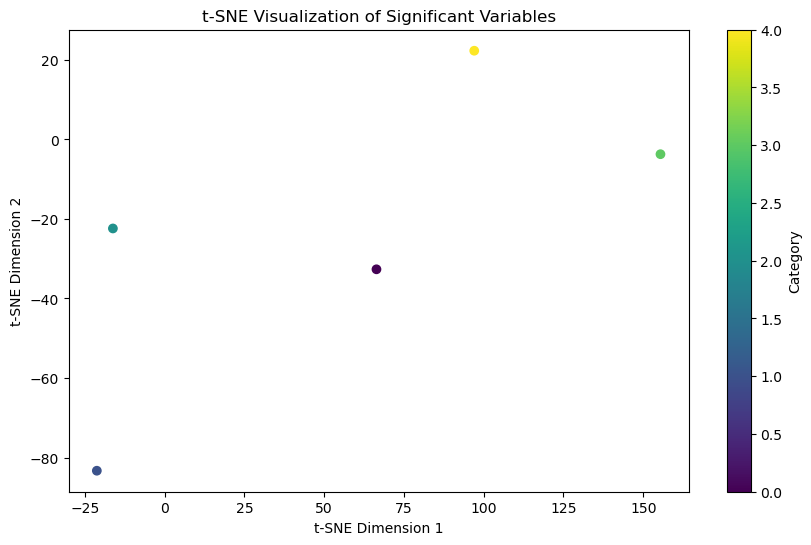

In [26]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Sample DataFrame (replace this with your actual data)
data = {
    'maturity_value': [1000, 2000, 1500, 1200, 1800],
    'category': ['S.A', 'I.T', 'D.A', 'T.H', 'J.K'],
    'currency': ['USD', 'GBP', 'USD', 'JPY', 'GBP'],
    'amount': [500, 800, 600, 700, 900]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Encode categorical variables
label_encoders = {}
categorical_vars = ['category', 'currency']
for var in categorical_vars:
    le = LabelEncoder()
    df[var] = le.fit_transform(df[var])
    label_encoders[var] = le

# Select significant variables for t-SNE
significant_vars = ['maturity_value', 'amount']

# Extract the selected significant variables
significant_data = df[significant_vars]

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=3, random_state=42)  # Adjust perplexity as needed
tsne_result = tsne.fit_transform(significant_data)

# Create a scatter plot of t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['category'], cmap='viridis')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Significant Variables')
plt.colorbar(label='Category')
plt.show()


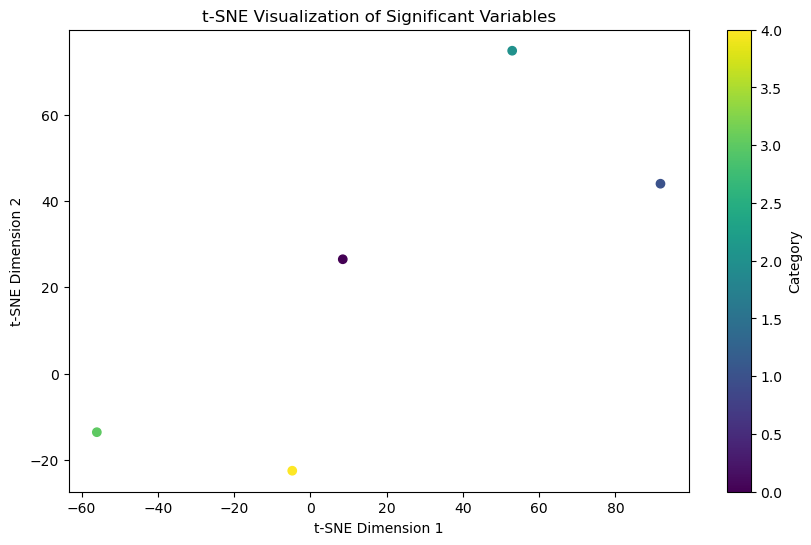

Most Significant Variables based on t-SNE:
maturity_value: Variance = 2551.4062
amount: Variance = 1310.6006


In [31]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Sample DataFrame (replace this with your actual data)
data = {
    'maturity_value': [1000, 2000, 1500, 1200, 1800],
    'category': ['S.A', 'I.T', 'D.A', 'T.H', 'J.K'],
    'currency': ['USD', 'GBP', 'USD', 'JPY', 'GBP'],
    'amount': [500, 800, 600, 700, 900]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Encode categorical variables
label_encoders = {}
categorical_vars = ['category', 'currency']
for var in categorical_vars:
    le = LabelEncoder()
    df[var] = le.fit_transform(df[var])
    label_encoders[var] = le

# Select significant variables for t-SNE
significant_vars = ['maturity_value', 'amount','category', 'currency']  # Update this list as needed

# Extract the selected significant variables
significant_data = df[significant_vars]

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=3, random_state=42)  # Adjust perplexity as needed
tsne_result = tsne.fit_transform(significant_data)

# Create a scatter plot of t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['category'], cmap='viridis')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Significant Variables')
plt.colorbar(label='Category')
plt.show()

# Determine significant variables based on t-SNE dimensions
variances = np.var(tsne_result, axis=0)
sorted_indices = np.argsort(variances)[::-1]
most_significant_vars = [significant_vars[i] for i in sorted_indices]
most_significant_variances = [variances[i] for i in sorted_indices]

# Print the most significant variables along with their variance values
print("Most Significant Variables based on t-SNE:")
for var, variance in zip(most_significant_vars, most_significant_variances):
    print(f"{var}: Variance = {variance:.4f}")

In [32]:
tsne_result.shape

(5, 2)

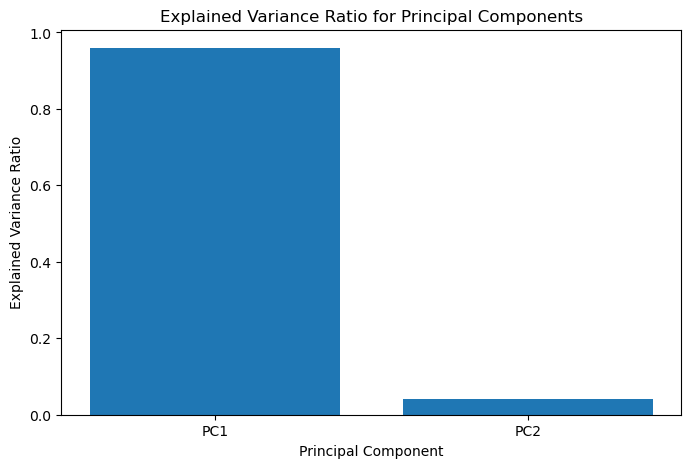

Most Significant Variables based on PCA:
maturity_value: Explained Variance = 0.9590
amount: Explained Variance = 0.0410


In [36]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Sample DataFrame (replace this with your actual data)
data = {
    'maturity_value': [1000, 2000, 1500, 1200, 1800],
    'category': ['S.A', 'I.T', 'D.A', 'T.H', 'J.K'],
    'currency': ['USD', 'GBP', 'USD', 'JPY', 'GBP'],
    'amount': [500, 800, 600, 700, 900]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Encode categorical variables
label_encoders = {}
categorical_vars = ['category', 'currency']
for var in categorical_vars:
    le = LabelEncoder()
    df[var] = le.fit_transform(df[var])
    label_encoders[var] = le

# Select significant variables for PCA
significant_vars = ['maturity_value', 'amount']  # Update this list as needed

# Extract the selected significant variables
significant_data = df[significant_vars]

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(significant_data)

# Create a scatter plot of explained variance ratio
plt.figure(figsize=(8, 5))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Principal Components')
plt.xticks(range(1, pca.n_components_ + 1), [f"PC{i}" for i in range(1, pca.n_components_ + 1)])  # Add this line
plt.show()

# Determine significant variables based on variance explained by principal components
variance_explained = pca.explained_variance_ratio_
sorted_indices = np.argsort(variance_explained)[::-1]
most_significant_vars = [significant_vars[i] for i in sorted_indices]
most_significant_variance_explained = [variance_explained[i] for i in sorted_indices]

# Print the most significant variables along with their variance explained by principal components
print("Most Significant Variables based on PCA:")
for var, explained_variance in zip(most_significant_vars, most_significant_variance_explained):
    print(f"{var}: Explained Variance = {explained_variance:.4f}")
